##Preprocessing phase

In [1]:
# !pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
import zipfile

In [2]:
url_fire_dataset = 'https://drive.google.com/u/0/uc?id=1XTDlTqZbjwwbhSDcA86LqrjuKmCcanfs&export=download'
base_path = ''

def download_from_drive():
  zip_path = base_path + 'fire_dataset.zip'
  extract_path = base_path
  img_folder = base_path + 'fire_dataset'

  if os.path.exists(img_folder) == False:
    if os.path.isfile(zip_path) == False:
      gdown.download(url_fire_dataset, zip_path, quiet=False, fuzzy=True)
    zip_ref = zipfile.ZipFile(zip_path, 'r')
    zip_ref.extractall(path=extract_path)
    zip_ref.close()

download_from_drive()

Downloading...
From: https://drive.google.com/uc?id=1XTDlTqZbjwwbhSDcA86LqrjuKmCcanfs
To: /content/fire_dataset.zip
100%|██████████| 405M/405M [00:11<00:00, 36.8MB/s]


In [3]:
def load_dataset(dataset_path):
  image_paths = list(paths.list_images(dataset_path))
  data = []

  for img in image_paths:
    image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    data.append(image)

  return np.array(data, dtype='float32')

In [4]:
# from pyimagesearch import config
from imutils import paths
import argparse
import sys
import random

fire_path = '/content/fire_dataset/fire_images'
non_fire_path = '/content/fire_dataset/non_fire_images'

fire_list = os.listdir(fire_path)
non_fire_list = os.listdir(non_fire_path)
classes = ['Fire', 'Non_Fire']

# total_list = fire_list + non_fire_list
# random.shuffle(total_list)

# images = cv2.imread(total_list)

In [5]:
fire_data = load_dataset(fire_path)
non_fire_data = load_dataset(non_fire_path)

# construct the class labels for the data
fireLabels = np.ones((fire_data.shape[0],))
nonFireLabels = np.zeros((non_fire_data.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fire_data, non_fire_data])
labels = np.hstack([fireLabels, nonFireLabels])
data /= 255

##Training phase

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1, shuffle=True)

number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)


X_train = X_train_flatten.T
X_test = X_test_flatten.T
y_train = y_train.T
y_test = y_test.T
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

X train flatten (798, 16384)
X test flatten (200, 16384)
x train:  (16384, 798)
x test:  (16384, 200)
y train:  (798,)
y test:  (200,)


In [7]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))

<ipython-input-7-156c480e4ee0>:14: RuntimeWarning: divide by zero encountered in log
  loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
<ipython-input-7-156c480e4ee0>:14: RuntimeWarning: invalid value encountered in multiply
  loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)


Cost after iteration 0: nan
Cost after iteration 100: 0.466019
Cost after iteration 200: 0.609777
Cost after iteration 300: 0.547044
Cost after iteration 400: 0.466582
Cost after iteration 500: 0.432371
Cost after iteration 600: 0.402456
Cost after iteration 700: 0.373319
Cost after iteration 800: 0.344567
Cost after iteration 900: 0.315821
Cost after iteration 1000: 0.286575
Cost after iteration 1100: 0.256114
Cost after iteration 1200: 0.223956
Cost after iteration 1300: 0.192867
Cost after iteration 1400: 0.176185


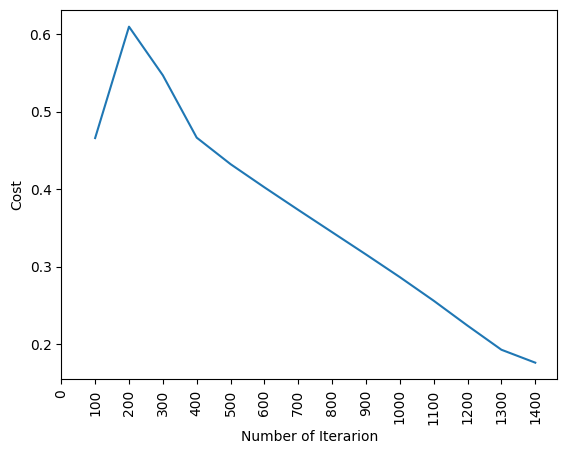

Test Accuracy: 78.5 %
Train Accuracy: 96.49 %


In [8]:
logistic_regression(X_train, y_train, X_test, y_test,learning_rate = 0.01, num_iterations = 1500)

In [9]:
clf =LogisticRegression(random_state=42)
clf.fit(X_train.T,y_train.T)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

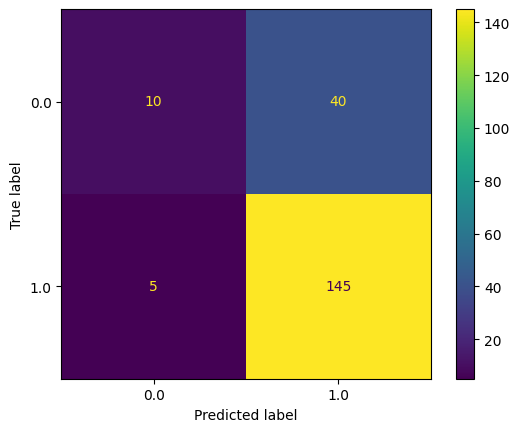

In [10]:
predictions = clf.predict(X_test.T)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [11]:
grid={"C":np.logspace(-3,3,7),"penalty":["l1","l2"]}
log_reg_cv=GridSearchCV(clf,grid,cv=2, n_jobs=2)
log_reg_cv.fit(X_train.T,y_train.T)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
14 fits failed out of a total of 28.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

GridSearchCV(cv=2, estimator=LogisticRegression(random_state=42), n_jobs=2,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [12]:
print("best hyperparameters: ", log_reg_cv.best_params_)
print("accuracy: ", log_reg_cv.best_score_)

best hyperparameters:  {'C': 0.001, 'penalty': 'l2'}
accuracy:  0.7543859649122806


In [13]:
log_reg= LogisticRegression(C=0.001, penalty='l2', solver='liblinear')
log_reg.fit(X_train.T,y_train.T)
print("test accuracy: {} ".format(log_reg.fit(X_test.T, y_test.T).score(X_test.T, y_test.T)))
print("train accuracy: {} ".format(log_reg.fit(X_train.T, y_train.T).score(X_train.T, y_train.T)))

test accuracy: 0.785 
train accuracy: 0.7656641604010025 


In [14]:
y_predict_prob = clf.predict_proba(X_test.T)
y_predict_prob_fire = y_predict_prob[:, 1]

In [15]:
y_predict_class_1 = [1 if prob > 0.4 else 0 for prob in y_predict_prob_fire]
print("Accuracy:", round(accuracy_score(y_test.T, y_predict_class_1), 3))

Accuracy: 0.77


In [16]:
y_predict_class_2 = [1 if prob > 0.6 else 0 for prob in y_predict_prob_fire]
print("Accuracy:", round(accuracy_score(y_test.T, y_predict_class_2), 3))

Accuracy: 0.76


In [17]:
import pickle

filename = 'classifier.py'
pickle.dump(log_reg, open(filename, 'wb'))
optimal_model = pickle.load(open(filename, 'rb'))
result = optimal_model.score(X_test.T, y_test.T)
print(result)

0.775


In [18]:
link = 'https://drive.google.com/u/0/uc?id=1z5zo5XwicHd7K471musPjn14hnbZIL7r&export=download'
zip_path = base_path + 'test_data.zip'

gdown.download(link,zip_path, quiet=False, fuzzy=True)
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall(path='')
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1z5zo5XwicHd7K471musPjn14hnbZIL7r
To: /content/test_data.zip
100%|██████████| 7.97M/7.97M [00:00<00:00, 11.1MB/s]


In [19]:
directory = '/content/download_data'

test_data = load_dataset(directory)
number_of_test = test_data.shape[0]

test_data_flatten = test_data.reshape(number_of_test,test_data.shape[1]*test_data.shape[2])
print("test flatten",test_data_flatten.shape)

test_data = test_data_flatten.T
print("test: ",test_data.shape)

test flatten (4, 16384)
test:  (16384, 4)


In [20]:
path = '/content/download_data/'
new_path = ''
filename = os.listdir(path)
font = cv2.FONT_HERSHEY_SIMPLEX
org = (50, 50)
fontScale = 1
thickness = 2

for (i, num) in enumerate(test_data.T):
  label = optimal_model.predict(np.expand_dims(num, axis=0))
  text = 'Fire' if label == 1 else 'non_Fire'
  img_path = os.path.join(path, filename[i])
  image = cv2.imread(img_path)
  image = cv2.resize(image, (128, 128))
  # output = image.copy()
  color = (255, 0, 0) if label == 1 else (0, 255, 0)
  image = cv2.putText(image, text, org, font, fontScale, color, thickness, cv2.LINE_AA)
  # dir = 'labelled images'
  # os.mkdir(dir)
  cv2.imwrite(f'img_{i}.png' ,image)


cv2.waitKey(0)
cv2.destroyAllWindows()

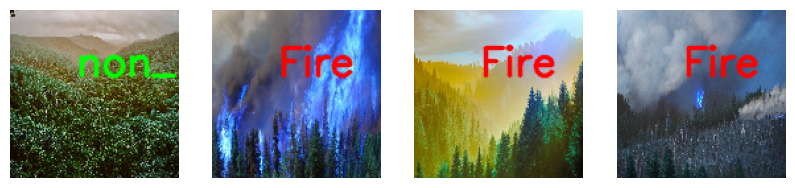

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))

for i in range(4): 
  img = cv2.imread(f'img_{i}.png')
  ax[i].imshow(img)
  ax[i].grid(False)
  ax[i].axis('off')